In [1]:
import torch
from torch_geometric import datasets
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
import matplotlib.pyplot as plt
from tqdm import tqdm

from losses import kl_div_vmf, reconstruction_loss
from train_utils import get_edge_probs
from models import VGAE
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = datasets.Planetoid(root='/__data/Cora', name='Cora', split='public')

In [5]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False) # because we perform negative sampling at each epoch ourselves

In [5]:
train_data, val_data, test_data = transform(dataset[0])

In [6]:
print('train data', train_data)
print('val data', val_data)
print('test data', test_data)

print(dataset[0].edge_index.shape[1])
print(train_data.pos_edge_label.size(0)*2 + val_data.pos_edge_label.size(0)*2  + test_data.pos_edge_label.size(0)*2)

train data Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])
val data Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263])
test data Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])
10556
10556


In [9]:
# train_data['neg_edge_label_index'] = negative_sampling(train_data.pos_edge_label_index)

In [7]:
feature_dim = dataset[0].x.shape[1]
print('input dim', feature_dim)

input dim 1433


## Check model forward pass

In [8]:
val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)
val_edge_label_index.shape

torch.Size([2, 526])

In [10]:
n_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='normal').to(device)

out_n_vgae, mus_n_vgae, logsigmas2s_n_vgae  = n_vgae(val_data.x.to(device), val_edge_label_index.to(device))
print('out', out_n_vgae.shape)
print('mus', mus_n_vgae.shape)
print('logsigmas2s', logsigmas2s_n_vgae.shape)
labs, edge_probs = get_edge_probs(out_n_vgae, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
print('edge probs', len(edge_probs)==len(labs))

out torch.Size([2708, 2708])
mus torch.Size([2708, 16])
logsigmas2s torch.Size([2708, 16])
edge probs True


In [9]:
s_vgae = VGAE(input_dim=feature_dim, latent_dim=16, dropout=0.0, latent_distr='vMF').to(device)


out_s_vgae, mus_s_vgae, logkappas_s_vgae  = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
print('out', out_s_vgae.shape)
print('mus', mus_s_vgae.shape)
print('logkappas', logkappas_s_vgae.shape)
labs, edge_probs = get_edge_probs(out_s_vgae, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
print('edge probs', len(edge_probs)==len(labs))

out torch.Size([2708, 2708])
mus torch.Size([2708, 16])
logkappas torch.Size([2708, 1])
edge probs True


In [10]:
num_epochs = 200
lr = 0.01
optimizer = torch.optim.Adam(s_vgae.parameters(), lr=lr)

## Train $\mathcal{S}$-VGAE

In [11]:
log_loss = {'train': [] }
log_metrics = {'val_auc' : [],
               'val_ap' : []}
val_edge_label_index = torch.cat([val_data.pos_edge_label_index, val_data.neg_edge_label_index], dim=1)

for epoch in range(num_epochs):

    # negative sampling 
    train_neg_edge_index = negative_sampling(train_data.pos_edge_label_index)
    train_data['edge_label_index'] = torch.cat([train_data.pos_edge_label_index, train_neg_edge_index], dim=1)


    kl = kl_div_vmf.apply
    
    optimizer.zero_grad()
    
    output, mus, logkappas = s_vgae(train_data.x.to(device), train_data.edge_label_index.to(device) )
    kappas = torch.exp(logkappas)
    loss = reconstruction_loss(output, train_data.pos_edge_label_index, train_neg_edge_index) - kl(kappas, mus) 
    
    loss.backward()

    optimizer.step()

    with torch.no_grad():
        out_val, mus_val, logkappas_val = s_vgae(val_data.x.to(device), val_edge_label_index.to(device))
        val_labs, edge_probs_val = get_edge_probs(out_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
        log_metrics['val_auc'].append(roc_auc_score(val_labs, edge_probs_val))
        log_metrics['val_ap'].append(average_precision_score(val_labs, edge_probs_val))
        log_loss['train'].append(loss.item())

        if epoch % 2 == 0:
            print('Epoch: {:3d}, VAL AUC: {:.4f}'.format(epoch, log_metrics['val_auc'][-1]))
            print(f'Epoch {epoch:3d}, TRAIN LOSS: {loss.item():.4f}')


Epoch:   0, VAL AUC: 0.4714
Epoch   0, TRAIN LOSS: -6423.5444
Epoch:   2, VAL AUC: 0.4963
Epoch   2, TRAIN LOSS: -6334.1657
Epoch:   4, VAL AUC: 0.4613
Epoch   4, TRAIN LOSS: -6314.2419


KeyboardInterrupt: 

In [73]:
def plot_curves(log_loss):
    fig, ax = plt.subplots()

    ax.plot(log_loss['train'], label='train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Learning curves')

    plt.show()  
    

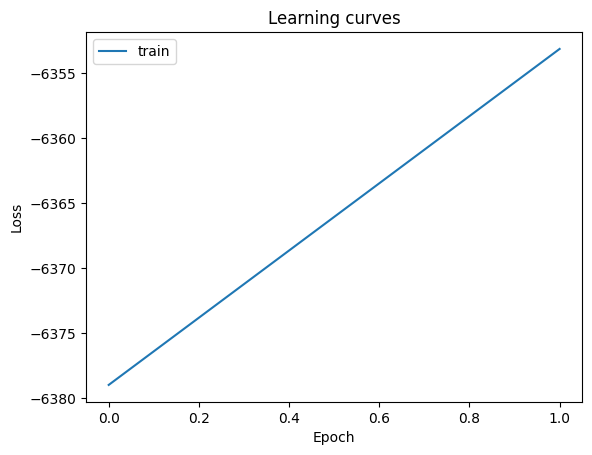

In [74]:
plot_curves(log_loss)

In [ ]:
log_metrics